In [1]:
import os
import glob
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
DATA_DIR = 'storage/Data/'
DATA_DIR = pathlib.Path(DATA_DIR)
IMG_SIZE = 150
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 20
EPOCHS = 7

In [3]:
CLASS_NAMES = np.array([item.name for item in DATA_DIR.glob('*')])
CLASS_NAMES

array(['Hot Dog', 'Not Hot Dog'], dtype='<U11')

In [4]:
list_ds = tf.data.Dataset.list_files(glob.glob('storage/Data/*/*'))

In [5]:
for f in list_ds.take(5):
  print(f.numpy())

b'storage/Data/Not Hot Dog/1420712475201.jpeg'
b'storage/Data/Not Hot Dog/portrait-faces-and-photography-french-woman-cover.jpg'
b'storage/Data/Hot Dog/images - 2020-04-17T130034.271.jpg'
b'storage/Data/Hot Dog/jamie-oliver-s-diner.jpg'
b'storage/Data/Hot Dog/19226-20180625_124643.jpg'


In [6]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  if parts[2] == 'Hot Dog':
      return 0
  else:
      return 1

In [7]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_image(img, channels=3, expand_animations=False)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [8]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [9]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  0


In [11]:
VAL_COUNT = 300
val_label_ds = labeled_ds.take(VAL_COUNT)
train_label_ds = labeled_ds.skip(VAL_COUNT)

In [12]:
tds = train_label_ds.cache()
tds = tds.shuffle(VAL_COUNT)
tds = tds.repeat()
tds = tds.batch(BATCH_SIZE)
tds = tds.prefetch(buffer_size=AUTOTUNE)

In [13]:
vds = val_label_ds.shuffle(VAL_COUNT)
vds = vds.repeat()
vds = vds.batch(BATCH_SIZE)
vds = vds.prefetch(buffer_size=AUTOTUNE)

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['binary_accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 256)       2

In [17]:
steps_per_epoch = 2614 // EPOCHS
steps_per_validation = 300 // EPOCHS

In [18]:
history = model.fit(tds, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=vds, validation_steps=steps_per_validation)

Train for 373 steps, validate for 42 steps
Epoch 1/7
373/373 [==============================] - 36s 97ms/step - loss: 0.4926 - binary_accuracy: 0.7710 - val_loss: 0.4099 - val_binary_accuracy: 0.8155
Epoch 2/7
373/373 [==============================] - 15s 40ms/step - loss: 0.3365 - binary_accuracy: 0.8554 - val_loss: 0.2700 - val_binary_accuracy: 0.8857
Epoch 3/7
373/373 [==============================] - 14s 38ms/step - loss: 0.1922 - binary_accuracy: 0.9197 - val_loss: 0.1055 - val_binary_accuracy: 0.9607
Epoch 4/7
373/373 [==============================] - 13s 34ms/step - loss: 0.0938 - binary_accuracy: 0.9651 - val_loss: 0.0980 - val_binary_accuracy: 0.9762
Epoch 5/7
373/373 [==============================] - 12s 32ms/step - loss: 0.0192 - binary_accuracy: 0.9938 - val_loss: 0.0582 - val_binary_accuracy: 0.9917
Epoch 6/7
373/373 [==============================] - 14s 37ms/step - loss: 0.0396 - binary_accuracy: 0.9867 - val_loss: 0.0593 - val_binary_accuracy: 0.9893
Epoch 7/7
373/3

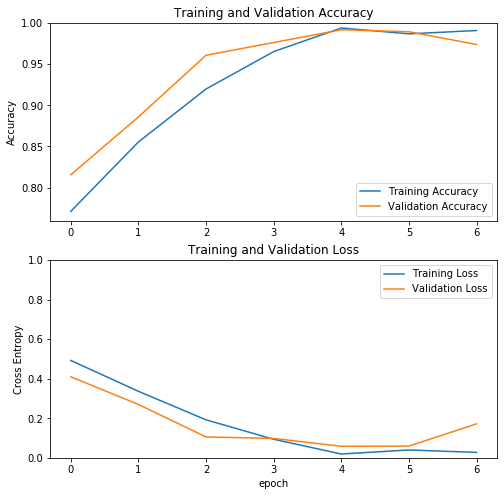

In [19]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
def get_label_name(x):
    if x == 0:
        return 'Hot Dog'
    else:
        return 'Not Hot Dog'

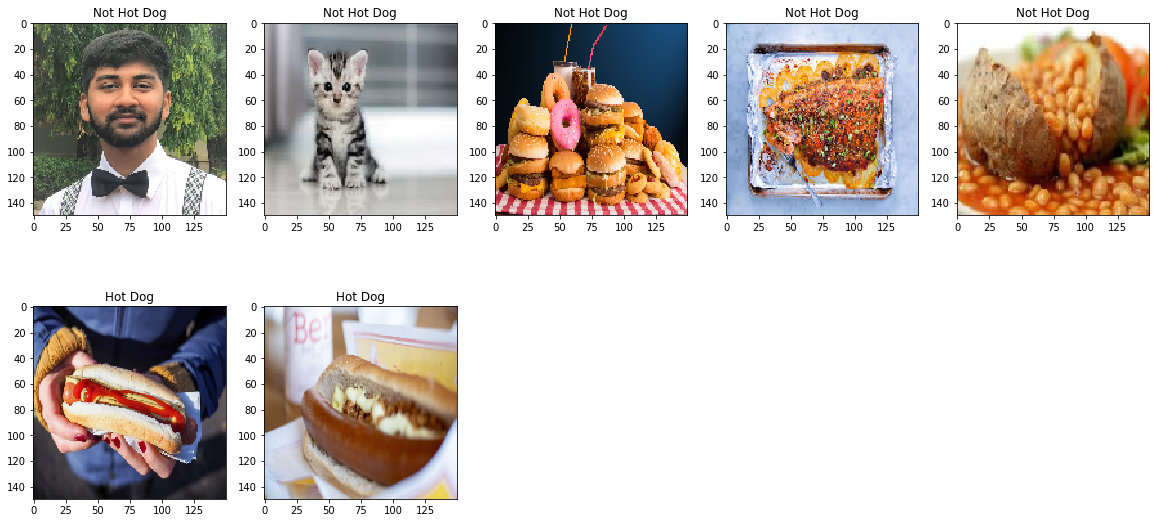

In [21]:
batch_holder = np.zeros((7, IMG_SIZE, IMG_SIZE, 3))
img_dir='Test/Test/'
for i, img in enumerate(os.listdir(img_dir)):
  img = tf.keras.preprocessing.image.load_img(os.path.join(img_dir,img), target_size=(IMG_SIZE,IMG_SIZE))
  batch_holder[i, :] = img

result=model.predict_classes(batch_holder)
 
fig = plt.figure(figsize=(20, 20))
 
for i,img in enumerate(batch_holder):
  fig.add_subplot(4,5, i+1)
  plt.title(get_label_name(result[i][0]))
  plt.imshow(img/255.)
  
plt.show()

In [22]:
model.save('hot dog clf_v2.h5', save_format='h5')